# Classify brain tumours from MRI images
Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [30]:
import torch
import torchvision
import os
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import rgb_to_grayscale

# Prepare dataset

In [18]:
path = os.getcwd()+"/data"
learning_rate = 1e-3
batch_size = 64
epochs = 20

In [31]:
transform = transforms.Compose([transforms.Grayscale(),
                              transforms.Resize(600),
                              transforms.CenterCrop(512),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

train_dataset = ImageFolder(root=(path+"/Training"), transform=transform)
test_dataset = ImageFolder(root=path+"/Testing", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([64, 1, 512, 512])


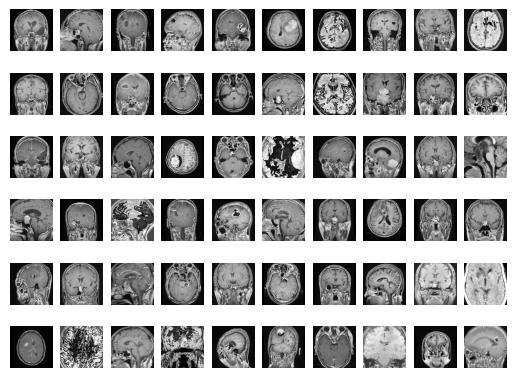

In [32]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

print(images.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(transforms.ToPILImage()(images[index]), cmap="gray")

# Setting up Neural Network

In [33]:
input_size = images.shape[2] * images.shape[3]
hidden_sizes = [128, 64]
output_size = 10

# nn.Sequential is an ordered container of modules
# nn.Linear applies a linear transformation on the input using its stored weights and biases
# nn.ReLU is a non-linear activation function (values < 0 = 0, values >= 0 remain the same)
# nn.LogSoftmax is the logarithm of the softmax function (i.e. sigmoid function)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack =  nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=262144, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


# Train and Test

In [34]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Training the model

In [35]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.264260  [    0/ 2870]
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.507843 

Epoch 2
-------------------------------
loss: 1.113933  [    0/ 2870]
Test Error: 
 Accuracy: 32.7%, Avg loss: 1.523089 

Epoch 3
-------------------------------
loss: 1.038589  [    0/ 2870]
Test Error: 
 Accuracy: 29.7%, Avg loss: 1.577536 

Epoch 4
-------------------------------
loss: 0.989261  [    0/ 2870]
Test Error: 
 Accuracy: 35.5%, Avg loss: 1.543536 

Epoch 5
-------------------------------
loss: 1.067122  [    0/ 2870]
Test Error: 
 Accuracy: 30.2%, Avg loss: 1.553689 

Epoch 6
-------------------------------
loss: 0.725801  [    0/ 2870]
Test Error: 
 Accuracy: 31.2%, Avg loss: 1.615420 

Epoch 7
-------------------------------
loss: 0.980542  [    0/ 2870]
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.606176 

Epoch 8
-------------------------------
loss: 0.867675  [    0/ 2870]
Test Error: 
 Accuracy: 33.8%, Avg loss: 1.525393 

Epoch 9
----------------